# Essai pre-traitement du dataset

## Librairies importation

In [4]:
import os
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
from nilearn import plotting, image
from nipype.interfaces.fsl import BET, FLIRT, MCFLIRT
from nipype.algorithms.misc import Gunzip
from nipype import Node, Workflow

# Définir les chemins
dataset_path = '/home/rduchadeau/Desktop/Brainhack_school/duchadeau_project/ds003768-download/'
fmri_path_sub_01_sess_01 = os.path.join(dataset_path, 'sub-01/func/sub-01_task-rest_run-1_bold.nii.gz')
t1_img_path = os.path.join(dataset_path, 'sub-01/anat/sub-01_T1w.nii.gz')


## Function definition

In [5]:
# Fonction pour redresser l'image avec FSL FLIRT
def fsl_flirt_resample(input_img_path, ref_img_path, output_img_path):
    flirt = FLIRT(in_file=input_img_path, reference=ref_img_path, out_file=output_img_path)
    flirt.run()

# Fonction pour visualiser une image 3D
def visualize_3d_img(img, title):
    plotting.plot_anat(img, title=title)
    plt.show()

# Fonction pour visualiser une image 4D (premier volume)
def visualize_4d_img(img, title):
    first_volume = image.index_img(img, 0)
    plotting.plot_epi(first_volume, title=title)
    plt.show()


## 1. Node definition and decompression of fMRI data

240605-10:04:44,2 nipype.workflow INFO:
	 [Node] Setting-up "gunzip_func" in "/tmp/tmpss4eocnq/gunzip_func".
240605-10:04:44,6 nipype.workflow INFO:
	 [Node] Executing "gunzip_func" <nipype.algorithms.misc.Gunzip>
240605-10:04:45,352 nipype.workflow INFO:
	 [Node] Finished "gunzip_func", elapsed time 1.34363s.


/home/rduchadeau/miniconda3/lib/python3.12/site-packages/nilearn/image/resampling.py:809: UserWarning: Casting data from int32 to float32
  return resample_img(


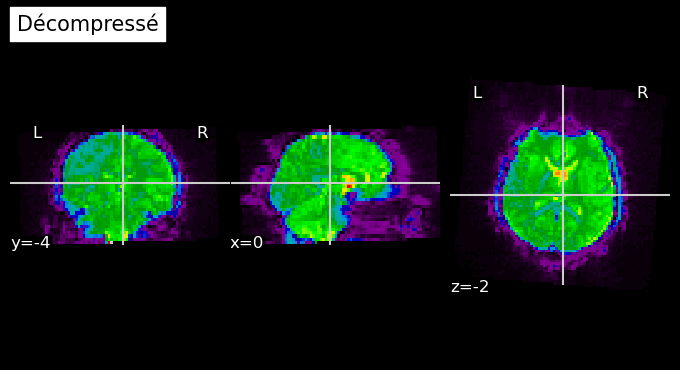

In [6]:
# Définir le noeud pour la décompression des fichiers gzip
gunzip_node = Node(Gunzip(), name='gunzip_func')
gunzip_node.inputs.in_file = fmri_path_sub_01_sess_01

# Exécuter Gunzip
gunzip_res = gunzip_node.run()

# Visualiser l'image décompressée
decompressed_img = nib.load(gunzip_res.outputs.out_file)
visualize_4d_img(decompressed_img, "Décompressé")

## 2. Mouvment correction

240605-10:04:51,4 nipype.workflow INFO:
	 [Node] Setting-up "mcflirt" in "/tmp/tmpwh1jycff/mcflirt".
240605-10:04:51,9 nipype.workflow INFO:
	 [Node] Executing "mcflirt" <nipype.interfaces.fsl.preprocess.MCFLIRT>
240605-10:06:04,317 nipype.workflow INFO:
	 [Node] Finished "mcflirt", elapsed time 73.306406s.


/home/rduchadeau/miniconda3/lib/python3.12/site-packages/nilearn/image/resampling.py:809: UserWarning: Casting data from int32 to float32
  return resample_img(


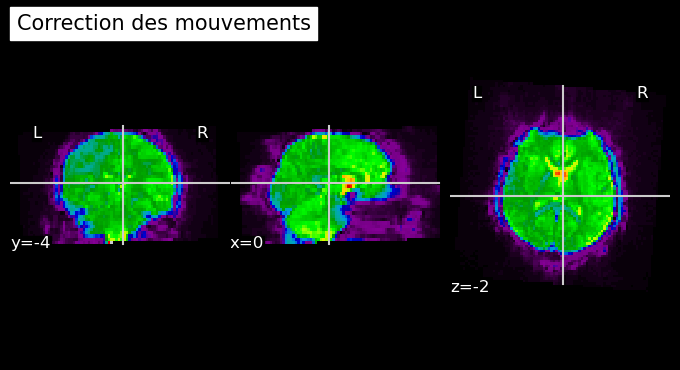

In [7]:
# Définir le noeud pour la correction des mouvements
mcflirt_node = Node(MCFLIRT(), name='mcflirt')
mcflirt_node.inputs.out_file = 'mcflirt_corrected.nii.gz'
mcflirt_node.inputs.in_file = gunzip_res.outputs.out_file

# Exécuter MCFLIRT pour la correction des mouvements
mcflirt_res = mcflirt_node.run()

# Visualiser l'image corrigée des mouvements
mcflirt_img = nib.load(mcflirt_res.outputs.out_file)
visualize_4d_img(mcflirt_img, "Correction des mouvements")

## 3. Brain extraction with BET

### Find the good extraction parameters

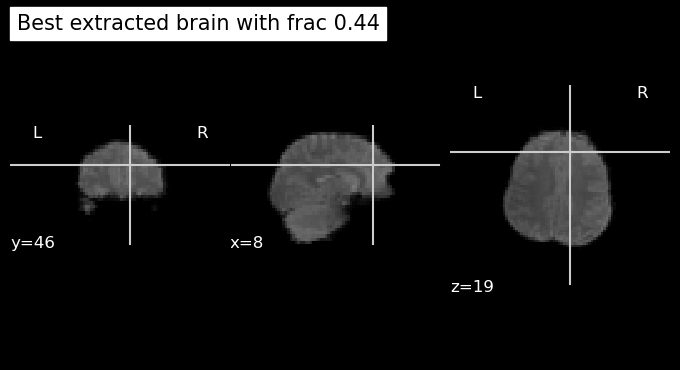

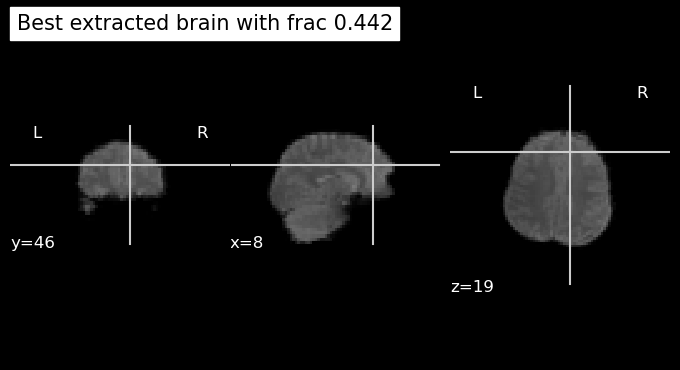

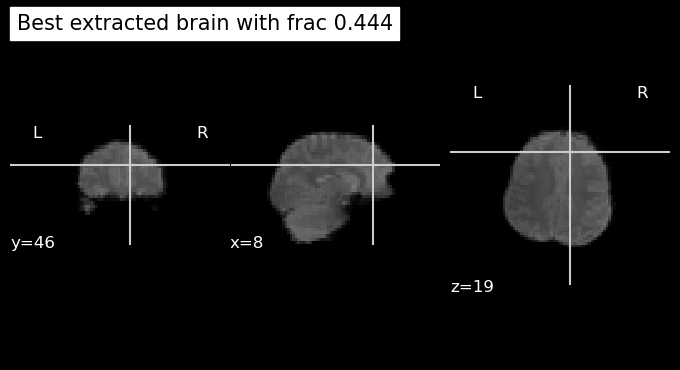

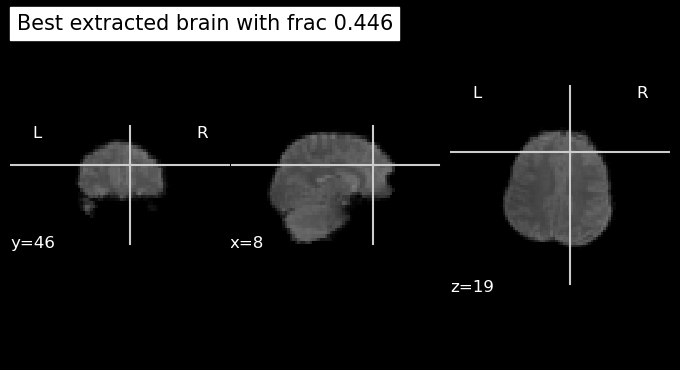

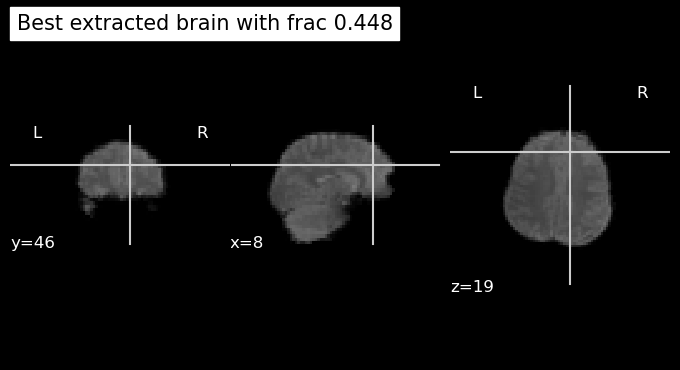

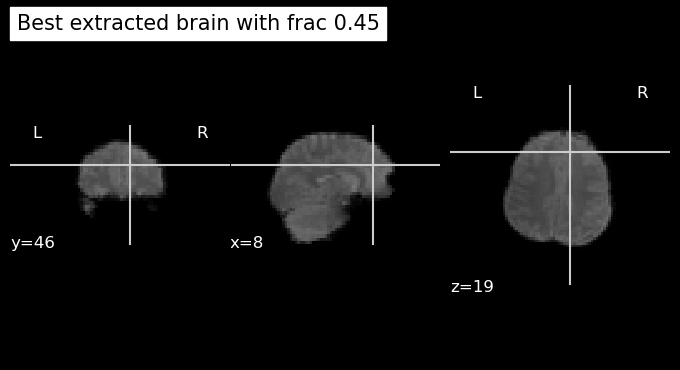

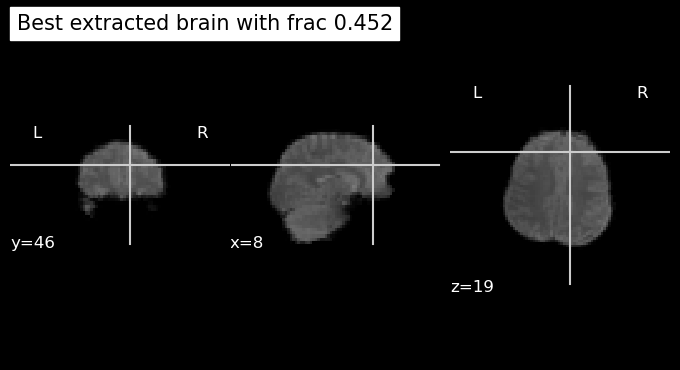

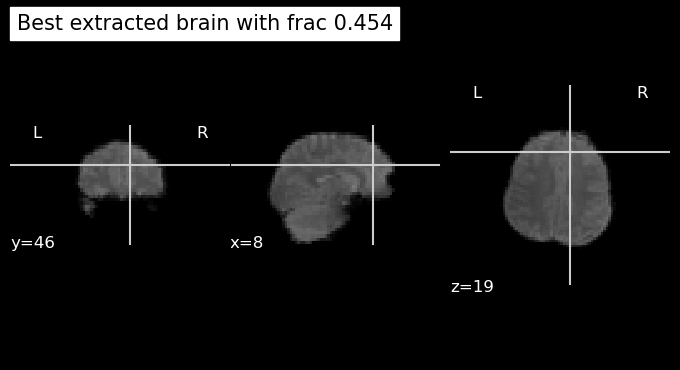

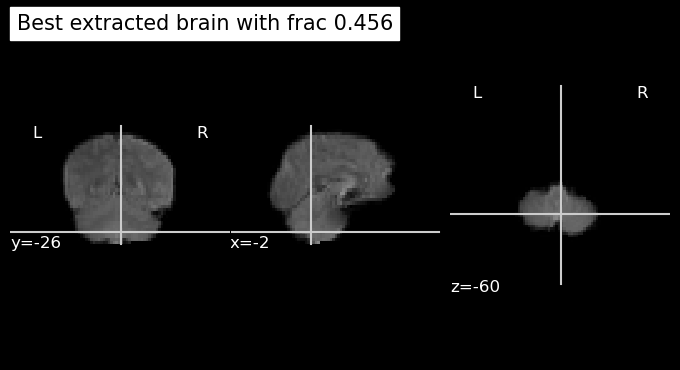

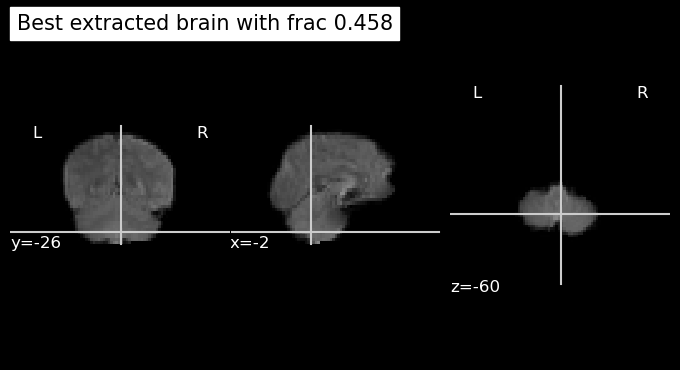

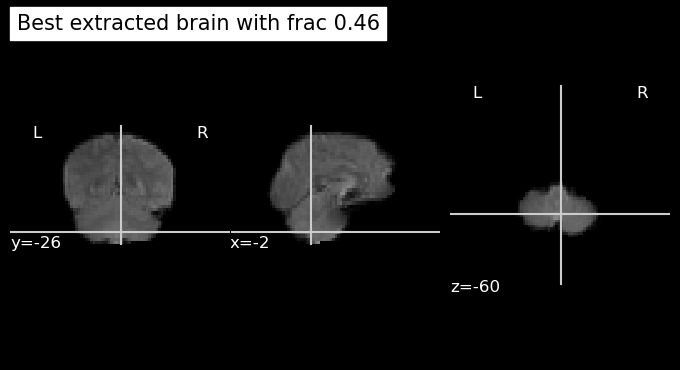

In [15]:
# Définir le noeud pour l'extraction avec BET
bet_node = Node(BET(), name='extract')
bet_node.inputs.out_file = 'output_brain.nii.gz'

# Extraire le premier volume de l'image corrigée des mouvements pour BET
first_vol_path = os.path.join('/home/rduchadeau/Desktop/Brainhack_school/duchadeau_project/working_directory', 'mcflirt_first_vol.nii.gz')
first_volume = image.index_img(mcflirt_img, 0)
nib.save(first_volume, first_vol_path)

# Initialisation
bet_node = BET()


for frac in np.arange(0.44, 0.46, 0.002):
    bet_node.inputs.frac = frac
    bet_node.inputs.in_file = first_vol_path
    bet_res = bet_node.run()
    
    # Verify if the extraction is successful
    extracted_img = nib.load(bet_res.outputs.out_file)
    # extracted_data = extracted_img.get_fdata()
    
    # Visualisation de l'image extraite
    plotting.plot_anat(extracted_img, title=f'Best extracted brain with frac {frac}')
    plotting.show()




## 4. Verification de l'alignement avec le T1

Vérification de l'alignement : 


/home/rduchadeau/miniconda3/lib/python3.12/site-packages/nilearn/image/resampling.py:809: UserWarning: Casting data from int32 to float32
  return resample_img(


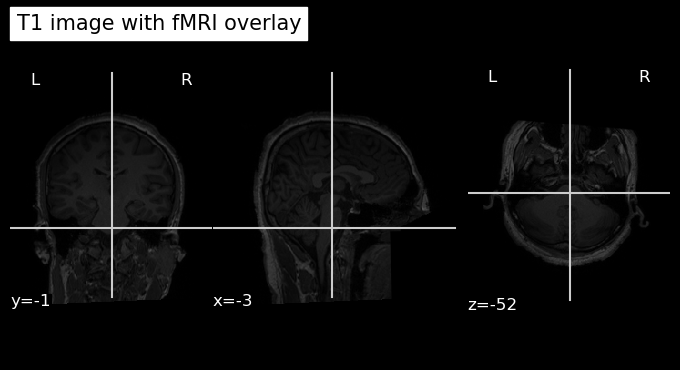

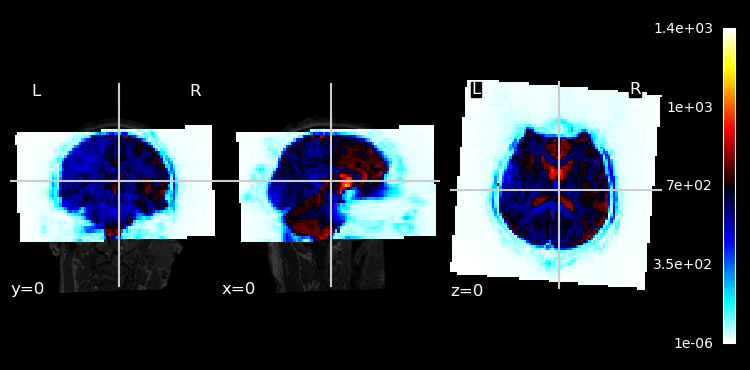

In [21]:
# Charger l'image T1
T1_image = nib.load(t1_img_path)

# Vérifier l'alignement en utilisant le premier volume de l'image fMRI corrigée
print("Vérification de l'alignement : ")
display = plotting.plot_anat(T1_image, title="T1 image with fMRI overlay")
first_volume_mcflirt = image.index_img(mcflirt_img, 0)
plotting.plot_stat_map(first_volume_mcflirt, bg_img=T1_image, display_mode='ortho', cut_coords=(0, 0, 0), draw_cross=True)
plt.show()


## 5. Assemblage du workflow

In [22]:
# Créer le workflow
preproc_workflow = Workflow(name='work_preproc', base_dir='/home/rduchadeau/Desktop/Brainhack_school/duchadeau_project/working_directory')

# Ajouter les noeuds au workflow
preproc_workflow.add_nodes([gunzip_node, bet_node, mcflirt_node])

# Connecter les noeuds
preproc_workflow.connect([
    (gunzip_node, mcflirt_node, [('out_file', 'in_file')]),
    (mcflirt_node, bet_node, [('out_file', 'in_file')])
])


    On peut maintenant utiliser le workflow au complet en appelant preproc_workflow si j'ai bien compris

## Tout d'un coup pour sub_02_sess_02: 

240605-09:58:27,508 nipype.workflow INFO:
	 [Node] Setting-up "work_preproc.gunzip_func" in "/tmp/tmplflbdgsz/work_preproc/gunzip_func".
240605-09:58:27,512 nipype.workflow INFO:
	 [Node] Executing "gunzip_func" <nipype.algorithms.misc.Gunzip>
240605-09:58:28,887 nipype.workflow INFO:
	 [Node] Finished "gunzip_func", elapsed time 1.3735249999999999s.


/home/rduchadeau/miniconda3/lib/python3.12/site-packages/nilearn/image/resampling.py:809: UserWarning: Casting data from int32 to float32
  return resample_img(


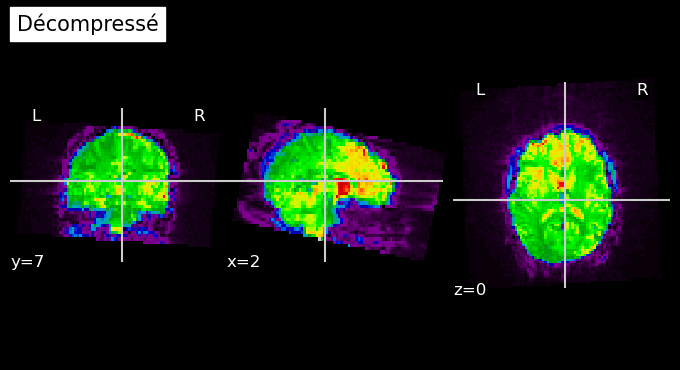

240605-09:58:29,865 nipype.workflow INFO:
	 [Node] Setting-up "work_preproc.mcflirt" in "/tmp/tmpa_d_hkyg/work_preproc/mcflirt".
240605-09:58:29,868 nipype.workflow INFO:
	 [Node] Executing "mcflirt" <nipype.interfaces.fsl.preprocess.MCFLIRT>
240605-09:59:42,546 nipype.workflow INFO:
	 [Node] Finished "mcflirt", elapsed time 72.676156s.


/home/rduchadeau/miniconda3/lib/python3.12/site-packages/nilearn/image/resampling.py:809: UserWarning: Casting data from int32 to float32
  return resample_img(


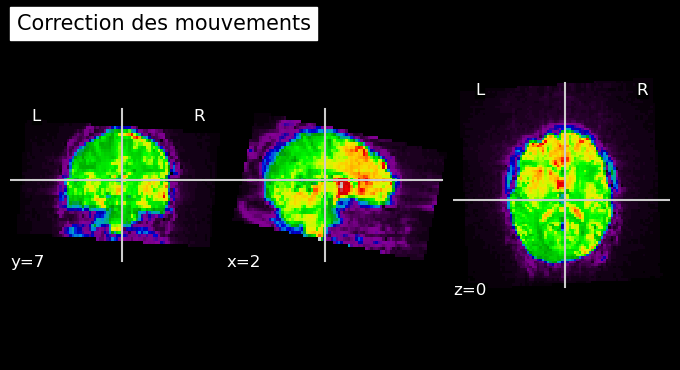

240605-09:59:44,435 nipype.workflow INFO:
	 [Node] Setting-up "work_preproc.extract" in "/tmp/tmpy68xgivj/work_preproc/extract".
240605-09:59:44,444 nipype.workflow INFO:
	 [Node] Executing "extract" <nipype.interfaces.fsl.preprocess.BET>
240605-09:59:45,928 nipype.workflow INFO:
	 [Node] Finished "extract", elapsed time 1.4809809999999999s.
240605-09:59:45,948 nipype.workflow INFO:
	 [Node] Setting-up "work_preproc.extract" in "/tmp/tmpy68xgivj/work_preproc/extract".
240605-09:59:45,953 nipype.workflow INFO:
	 [Node] Cached "work_preproc.extract" - collecting precomputed outputs
240605-09:59:45,953 nipype.workflow INFO:
	 [Node] "work_preproc.extract" found cached.
240605-09:59:45,970 nipype.workflow INFO:
	 [Node] Setting-up "work_preproc.extract" in "/tmp/tmpy68xgivj/work_preproc/extract".
240605-09:59:45,971 nipype.workflow INFO:
	 [Node] Cached "work_preproc.extract" - collecting precomputed outputs
240605-09:59:45,972 nipype.workflow INFO:
	 [Node] "work_preproc.extract" found ca

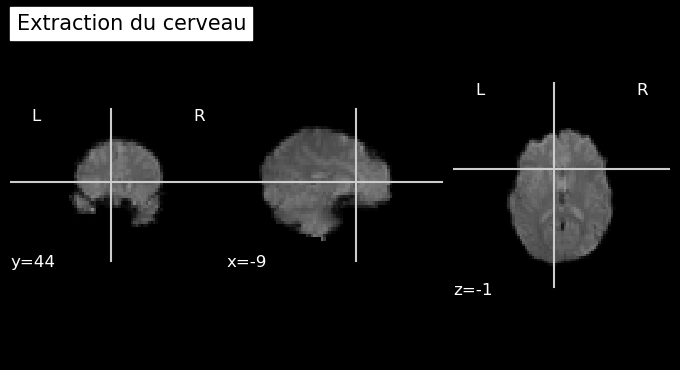

Vérification de l'alignement : 


/home/rduchadeau/miniconda3/lib/python3.12/site-packages/nilearn/image/resampling.py:809: UserWarning: Casting data from int32 to float32
  return resample_img(


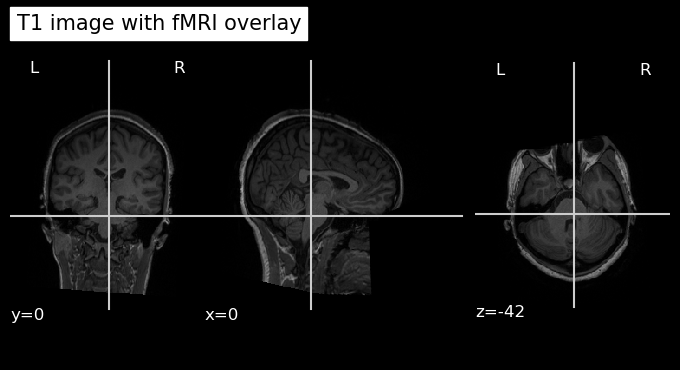

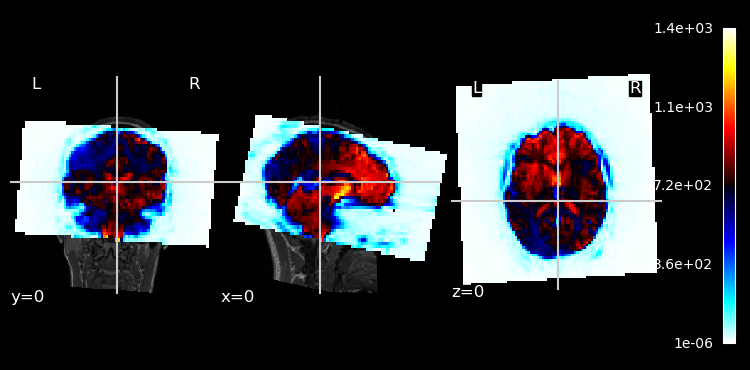

In [3]:
import os
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
from nilearn import plotting, image
from nipype.interfaces.fsl import BET, FLIRT, MCFLIRT
from nipype.algorithms.misc import Gunzip
from nipype import Node, Workflow

# Définir les chemins
dataset_path = '/home/rduchadeau/Desktop/Brainhack_school/duchadeau_project/ds003768-download/'
fmri_path_sub_02_sess_02 = os.path.join(dataset_path, 'sub-02/func/sub-02_task-rest_run-2_bold.nii.gz')
t1_img_path = os.path.join(dataset_path, 'sub-02/anat/sub-02_T1w.nii.gz')

# Fonction pour redresser l'image avec FSL FLIRT
def fsl_flirt_resample(input_img_path, ref_img_path, output_img_path):
    flirt = FLIRT(in_file=input_img_path, reference=ref_img_path, out_file=output_img_path)
    flirt.run()

# Définir le noeud pour la décompression des fichiers gzip
gunzip_node = Node(Gunzip(), name='gunzip_func')
gunzip_node.inputs.in_file = fmri_path_sub_02_sess_02

# Définir le noeud pour l'extraction avec BET
bet_node = Node(BET(), name='extract')
bet_node.inputs.out_file = 'output_brain.nii.gz'

# Définir le noeud pour la correction des mouvements
mcflirt_node = Node(MCFLIRT(), name='mcflirt')
mcflirt_node.inputs.out_file = 'mcflirt_corrected.nii.gz'

# Créer le workflow
preproc_workflow = Workflow(name='work_preproc', base_dir='/home/rduchadeau/Desktop/Brainhack_school/duchadeau_project/working_directory')

# Ajouter les noeuds au workflow
preproc_workflow.add_nodes([gunzip_node, bet_node, mcflirt_node])

# Connecter les noeuds
preproc_workflow.connect([
    (gunzip_node, mcflirt_node, [('out_file', 'in_file')]),
    (mcflirt_node, bet_node, [('out_file', 'in_file')])
])

# Fonction pour visualiser une image 3D
def visualize_3d_img(img, title):
    plotting.plot_anat(img, title=title)
    plt.show()

# Fonction pour visualiser une image 4D (premier volume)
def visualize_4d_img(img, title):
    first_volume = image.index_img(img, 0)
    plotting.plot_epi(first_volume, title=title)
    plt.show()

########## Main ###########
# Exécuter le workflow étape par étape pour insérer des visualisations
# Exécuter Gunzip
gunzip_res = gunzip_node.run()

# Visualiser l'image décompressée
decompressed_img = nib.load(gunzip_res.outputs.out_file)
visualize_4d_img(decompressed_img, "Décompressé")

# Exécuter MCFLIRT pour la correction des mouvements
mcflirt_node.inputs.in_file = gunzip_res.outputs.out_file
mcflirt_res = mcflirt_node.run()

# Visualiser l'image corrigée des mouvements
mcflirt_img = nib.load(mcflirt_res.outputs.out_file)
visualize_4d_img(mcflirt_img, "Correction des mouvements")

# Extraire le premier volume de l'image corrigée des mouvements pour BET
first_vol_path = os.path.join(preproc_workflow.base_dir, 'mcflirt_first_vol.nii.gz')
first_volume = image.index_img(mcflirt_img, 0)
nib.save(first_volume, first_vol_path)

# Essayer plusieurs valeurs de fraction pour BET
best_frac = 0.3  # Initialiser avec une valeur par défaut
best_extracted_img = None

for frac in np.arange(0.28, 0.52, 0.02):
    bet_node.inputs.frac = frac
    bet_node.inputs.in_file = first_vol_path
    bet_res = bet_node.run()
    
    # Vérifier si l'extraction est réussie
    extracted_img = nib.load(bet_res.outputs.out_file)
    extracted_data = extracted_img.get_fdata()
    
    # Critère pour sélectionner la meilleure extraction (à définir selon les besoins)
    # Ici, nous choisissons la fraction avec la plus grande moyenne de l'image extraite
    mean_intensity = np.mean(extracted_data)
    if best_extracted_img is None or mean_intensity > np.mean(best_extracted_img.get_fdata()):
        best_extracted_img = extracted_img
        best_frac = frac

print(f"Meilleure fraction pour BET: {best_frac}")
visualize_3d_img(best_extracted_img, "Extraction du cerveau")

# Charger l'image T1
T1_image = nib.load(t1_img_path)

# Vérifier l'alignement en utilisant le premier volume de l'image fMRI corrigée
print("Vérification de l'alignement : ")
display = plotting.plot_anat(T1_image, title="T1 image with fMRI overlay")
first_volume_mcflirt = image.index_img(mcflirt_img, 0)
plotting.plot_stat_map(first_volume_mcflirt, bg_img=T1_image, display_mode='ortho', cut_coords=(0, 0, 0), draw_cross=True)
plt.show()
